# Modelos: NeurIPS 2024 - Predict New Medicines with BELKA

Para la realización de este ejercicio, vamos a trabajar con las bases de datos ajustadas en el Punto 2.1 para el entrenamiento de los modelos de clasificación.

## Librerías

In [26]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
)

warnings.filterwarnings("ignore")

## Modelos

### Proteína EPHX2 - sEH

Primero importamos la base de datos.

In [27]:
dataseh = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/datatrainsEH.csv")

Ahora proseguiremos con los modelos.

#### KNN

In [28]:
X_seh = dataseh.drop(columns='binds') # Se toman todas las columnas excepto la objetivo
y_seh = dataseh['binds'] # Se toma solo la columna objetivo

#Particionamos conjunto entrenamiento pues conjunto test no cuenta con la variable objetivo.
X_trainseh, X_testseh, y_trainseh, y_testseh = train_test_split(X_seh, y_seh, stratify= y_seh, random_state=21) 

In [29]:
knn_pipelineseh = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier(weights='distance'))]) #Creación del Pipeline
knn_paramgridseh = {'KNN__n_neighbors': list(range(1, 150))} #Hiperparámetros

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)

knn_gridseh = GridSearchCV(knn_pipelineseh, knn_paramgridseh, cv=skf, scoring='roc_auc')
knn_gridseh.fit(X_trainseh, y_trainseh)

print("Mejor score de conjunto de entrenamiento :", knn_gridseh.best_score_)
print("Mejor parámetro: ", knn_gridseh.best_params_)

ypredknnseh = knn_gridseh.predict_proba(X_testseh)[:, 1] # Se trabaja con predict_proba porque la métrica es auc
auc = roc_auc_score(y_testseh, ypredknnseh)

print('Mejor score de conjunto de test:', auc)

Mejor score de conjunto de entrenamiento : 0.9490003439894383
Mejor parámetro:  {'KNN__n_neighbors': 148}
Mejor score de conjunto de test: 0.9310476191727636


Es decir que la cantidad óptima de vecinos sería 148. También vemos que los scores de entrenamiento y test son cercanos y a la vez altos, esto da indicio de una buena predicción.

#### Regresión logística

In [30]:
X_seh = dataseh.drop(columns='binds')  
y_seh = dataseh['binds'] 

X_trainseh, X_testseh, y_trainseh, y_testseh = train_test_split(X_seh, y_seh, stratify= y_seh, random_state=21)

In [31]:
lr_pipelineseh = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())]) 
lr_paramgridseh = {'lr__C': [0.01, 0.1, 1, 10, 100]}

lr_gridseh = GridSearchCV(lr_pipelineseh, lr_paramgridseh, cv=5, scoring='roc_auc')
lr_gridseh.fit(X_trainseh, y_trainseh)

ypredlrseh = lr_gridseh.predict_proba(X_testseh)[:, 1]
auc = roc_auc_score(y_testseh, ypredlrseh)

print("Mejor score de conjunto de entrenamiento:", lr_gridseh.best_score_)
print("Mejor parámetro: ", lr_gridseh.best_params_)
print('Mejor score de conjunto de test:',auc)

Mejor score de conjunto de entrenamiento: 0.9684674758381405
Mejor parámetro:  {'lr__C': 0.01}
Mejor score de conjunto de test: 0.9421435241639335


En este caso tenemos que el mejor parámetro es 0.01, viendo que los scores de entrenamiento y test son cercanos.

#### Cuadro 1: Modelo de clasificación para predicción de unión entre molécula y proteína sEH.

In [32]:
KNN_seh = knn_gridseh.predict(X_testseh)
LR_seh = lr_gridseh.predict(X_testseh)

probknnseh = knn_gridseh.predict_proba(X_testseh)[:, 1]
problrseh = lr_gridseh.predict_proba(X_testseh)[:, 1]

metricas = {
    'Modelo': ['KNN', 'Regresión logística'],
    'Precision': [
        precision_score(y_testseh, KNN_seh), # KNN
        precision_score(y_testseh, LR_seh) # Regresión logística
    ],
    'Recall': [
        recall_score(y_testseh, KNN_seh),
        recall_score(y_testseh, LR_seh)
    ],
    'F1 Score': [
        f1_score(y_testseh, KNN_seh),
        f1_score(y_testseh, LR_seh)
    ],
    
    'ROC AUC': [
        roc_auc_score(y_testseh, probknnseh), 
        roc_auc_score(y_testseh, problrseh)  
    ]
}

cuadro1 = pd.DataFrame(metricas)
cuadro1 

,Modelo,Precision,Recall,F1 Score,ROC AUC
0,KNN,0.560000,0.304348,0.394366,0.931048
1,Regresión logística,0.672269,0.434783,0.528053,0.942144


Podemos observar que, en términos generales, las métricas predicen mejor el modelo usando regresión logística debido a que el score de este es el mayor en todas las métricas.

Además, se puede concluir que esa diferencia entre los scores de las métricas puede estar dado por el desbalanceo propio de la base de datos, y porque AUC se basa en probabilidades mientras que las demás no.

#### Matrices de confusión

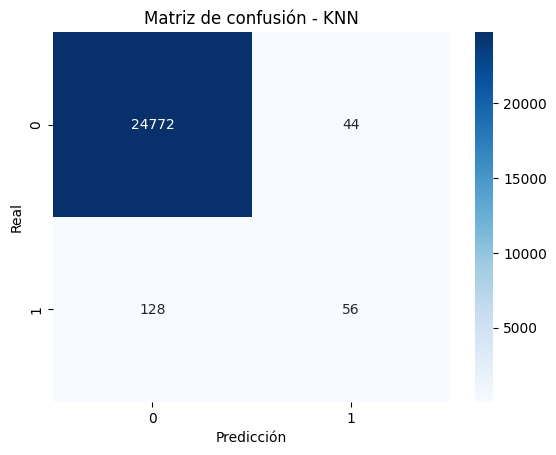

In [33]:
ypredknnseh_cm = (ypredknnseh >= 0.5).astype(int) # Pasar predictor a número

knncmseh = confusion_matrix(y_testseh, ypredknnseh_cm) # Matriz de confusión

sns.heatmap(knncmseh, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - KNN')
plt.show()

Podemos observar que el modelo presenta un alto número de verdaderos negativos, es decir, predijo correctamente que 24772 proteínas no estaban unidas con alguna molécula. Por otra parte, los verdaderos positivos (56) no fueron tan altos cómo se desearía. También se puede notar que las predicciones falsas no fueron tan altas, siendo estas 128 falsos negativos y 44 falsos positivos. 

Cabe mencionar que tanto en los falsos como en los positivos, la mayor predicción la obtuvo la clase negativa por el desbalanceo de la base.

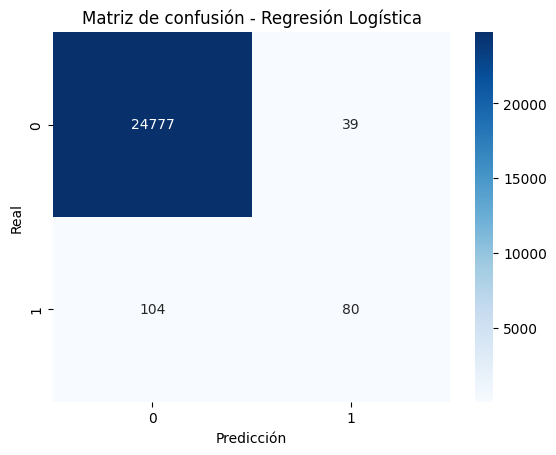

In [34]:
ypredlrseh_cm = (ypredlrseh  >= 0.5).astype(int)

lrcmseh = confusion_matrix(y_testseh, ypredlrseh_cm)

sns.heatmap(lrcmseh, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Regresión Logística')
plt.show()

La matriz de este modelo sigue el mismo patrón de KNN, pues, en este caso la mayor cantidad de predicciones la obtuvo el grupo de verdaderos negativos con 24777. Asímismo, los verdaderos positivos (80) tampoco obtuvieron una cantidad de predicciones significativa. Al igual que las predicciones falsas donde los positivos obtuvieron 39 y los negativos 104. Esto da entender que el modelo predice de manera más efectiva el hecho de que la molécula y la proteína no estén unidas.

Cabe mencionar que tanto en los falsos como en los positivos, la mayor predicción la obtuvo la clase negativa por el desbalanceo de la base.

#### Curvas ROC

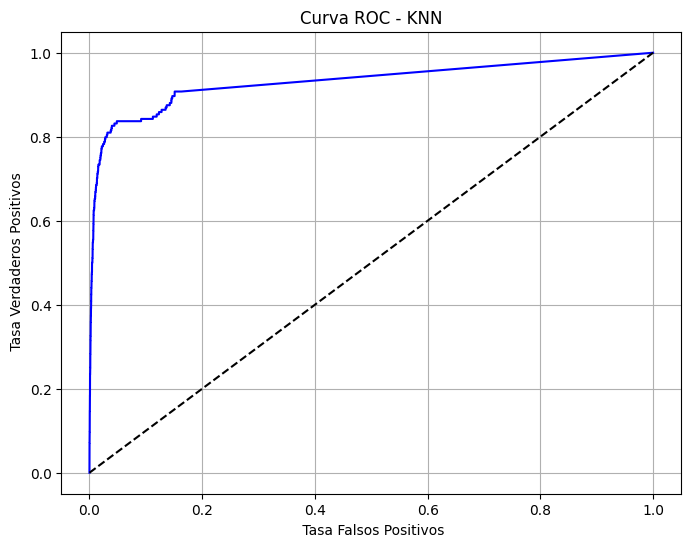

In [35]:
fpr, tpr, thresholds = roc_curve(y_testseh, ypredknnseh)
knnaucseh = roc_auc_score(y_testseh, ypredknnseh)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC KNN (AUC = {knnaucseh:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - KNN')
plt.grid(True)
plt.show()

Recordemos que el AUC de este modelo es 0.931048, de entrada esto nos habla de que el modelo cuenta con buen rendimiento en términos de sensibilidad y especificidad. Además, gráficamente, observamos que la curva está bastante alejada de la diagonal por lo que podemos afirmar que en las predicciones se encuentra un balance entre los verdaderos positivos y los falsos positivos.

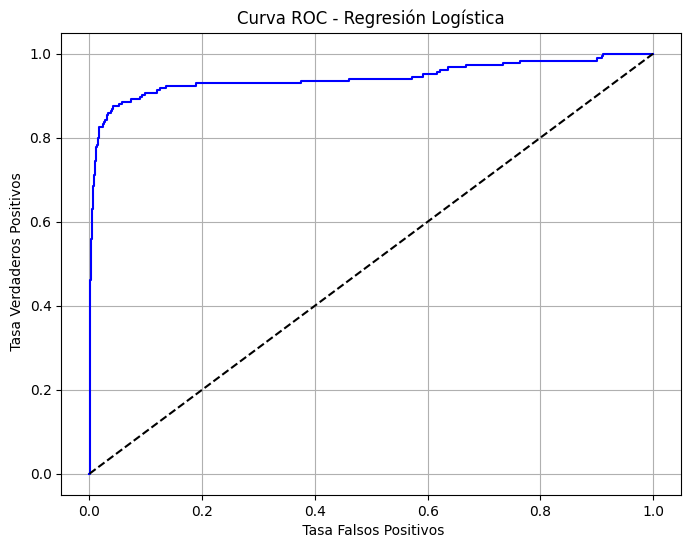

In [36]:
fpr, tpr, thresholds = roc_curve(y_testseh, ypredlrseh)
lraucseh = roc_auc_score(y_testseh, ypredlrseh)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC Regresión Logística (AUC = {lraucseh:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.grid(True)
plt.show()

Para este modelo nuestro AUC es 0.942144, al igual que KNN cuenta con un buen rendimiento. En este caso también podemos ver que la curva está bastante distante de la diagonal por lo que se puede afirmar que existe un buen balance entre las predicciones de ambos grupos.

### Proteína BRD4


Procedemos a importar la base de datos.

In [37]:
databrd4 = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/datatrainbrd4.csv")

#### KNN

In [38]:
X_brd4 = databrd4.drop(columns='binds')  
y_brd4 = databrd4['binds'] 

X_trainbrd4, X_testbrd4, y_trainbrd4, y_testbrd4 = train_test_split(X_brd4, y_brd4, stratify= y_brd4, random_state=21)

In [39]:
knn_pipelinebrd4 = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier(weights='distance'))]) #Creación del Pipeline
knn_paramgridbrd4 = {'KNN__n_neighbors': list(range(1,150))} #Parámetro grid

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)

knn_gridbrd4 = GridSearchCV(knn_pipelinebrd4, knn_paramgridbrd4, cv=skf, scoring='roc_auc')
knn_gridbrd4.fit(X_trainbrd4, y_trainbrd4)

print("Mejor score de conjunto de entrenamiento :", knn_gridbrd4.best_score_)
print("Mejor parámetro: ", knn_gridbrd4.best_params_)

ypredknnbrd4 = knn_gridbrd4.predict_proba(X_testbrd4)[:, 1]
auc = roc_auc_score(y_testbrd4, ypredknnbrd4)

print('Mejor score de conjunto de test:', auc)

Mejor score de conjunto de entrenamiento : 0.8899296562577117
Mejor parámetro:  {'KNN__n_neighbors': 148}
Mejor score de conjunto de test: 0.8225783151062309


Nuevamente la cantidad óptima de vecinos es 148 y los scores de entrenamiento y test son cercanos y altos, por lo que se puede pensar que es una buena predicción.

#### Regresión logística

In [40]:
X_brd4 = databrd4.drop(columns='binds')  
y_brd4 = databrd4['binds'] 

X_trainbrd4, X_testbrd4, y_trainbrd4, y_testbrd4 = train_test_split(X_brd4, y_brd4, stratify= y_brd4, random_state=21)

In [41]:
lr_pipelinebrd4 = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())]) 
lr_paramgridbrd4 = {'lr__C': [0.01, 0.1, 1, 10, 100]}

lr_gridbrd4 = GridSearchCV(lr_pipelinebrd4, lr_paramgridbrd4, cv=5, scoring='roc_auc')
lr_gridbrd4.fit(X_trainbrd4, y_trainbrd4)

ypredlrbrd4 = lr_gridbrd4.predict_proba(X_testbrd4)[:,1]
auc = roc_auc_score(y_testbrd4, ypredlrbrd4)

print("Mejor score de conjunto de entrenamiento:",lr_gridbrd4.best_score_)
print("Mejor parámetro: ", lr_gridbrd4.best_params_)
print('Mejor score de conjunto de test:',auc)

Mejor score de conjunto de entrenamiento: 0.9348379462242326
Mejor parámetro:  {'lr__C': 0.01}
Mejor score de conjunto de test: 0.9431157120764485


Aquí observamos que el modelo se entrenó bastante bien pues el score del test es mayor al de entrenamiento. Por otro lado, nuevamente el mejor parámetro resultó ser 0.01.

#### Cuadro 2: Modelo de clasificación para predicción de unión entre molécula y proteína BRD4.

In [42]:
KNN_brd4 = knn_gridbrd4.predict(X_testbrd4)
LR_brd4 = lr_gridbrd4.predict(X_testbrd4)

probknnbrd4 = knn_gridbrd4.predict_proba(X_testbrd4)[:, 1]
problrbrd4 = lr_gridbrd4.predict_proba(X_testbrd4)[:, 1]

metricas = {
    'Modelo': ['KNN', 'Regresión logística'],
    'Precision': [
        precision_score(y_testbrd4, KNN_brd4), # K-NN
        precision_score(y_testbrd4, LR_brd4) # Regresión logística
    ],
    'Recall': [
        recall_score(y_testbrd4, KNN_brd4),
        recall_score(y_testbrd4, LR_brd4)
    ],
    'F1 Score': [
        f1_score(y_testbrd4, KNN_brd4),
        f1_score(y_testbrd4, LR_brd4)
    ],
    'ROC AUC': [
        roc_auc_score(y_testbrd4, probknnbrd4), 
        roc_auc_score(y_testbrd4, problrbrd4)  
    ]
}

cuadro2 = pd.DataFrame(metricas)
cuadro2 

,Modelo,Precision,Recall,F1 Score,ROC AUC
0,KNN,0.344828,0.086207,0.137931,0.822578
1,Regresión logística,0.468750,0.129310,0.202703,0.943116


Podemos darnos cuenta de que el modelo de regresión logística es mejor prediciendo que el de KNN dado que los scores de todas sus métricas son mayores comparadas con el segundo grupo mencionado.

#### Matrices de confusión

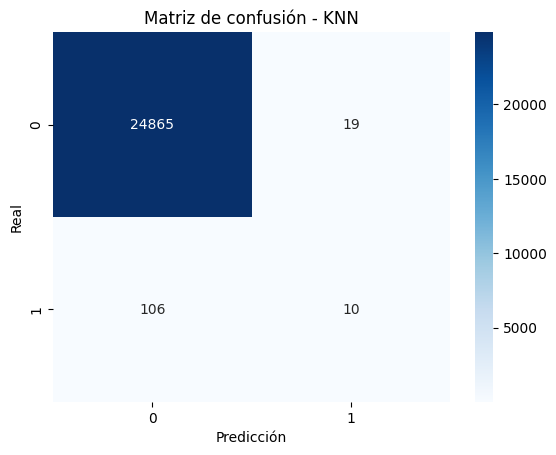

In [43]:
ypredknnbrd4_cm = (ypredknnbrd4 >= 0.5).astype(int)

knncmbrd4 = confusion_matrix(y_testbrd4, ypredknnbrd4_cm)

sns.heatmap(knncmbrd4, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - KNN')
plt.show()


La mayor cantidad de predicciones realizadas fue 24865 al grupo de verdaderos negativos lo que quiere decir que está bien entrenado en ese aspecto. Por otra parte, los verdaderos positivos fueron muy pocos (10), algo no tan desebale en este contexto. También se puede notar que las predicciones falsas no fueron tan altas, siendo estas 109 falsos negativos y 19 falsos positivos, lo cual afecta la intención de los fármacos. 

Cabe mencionar que tanto en los falsos como en los positivos, la mayor predicción la obtuvo la clase negativa por el desbalanceo de la base.

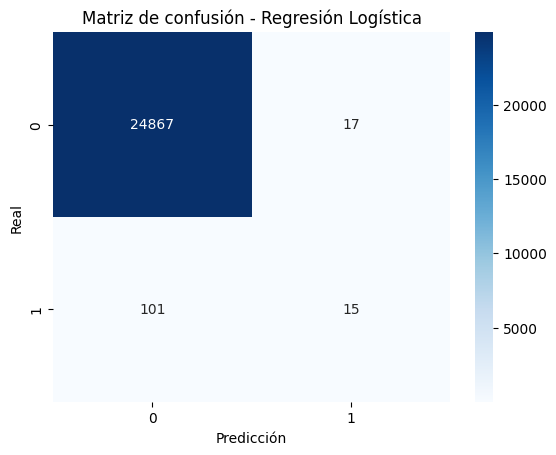

In [44]:
ypredlrbrd4_cm  = (ypredlrbrd4  >= 0.5).astype(int)

lrcmbrd4 = confusion_matrix(y_testbrd4, ypredlrbrd4_cm)

sns.heatmap(lrcmbrd4, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Regresión Logística')
plt.show()

La cantidad de predicciones de verdaderos negativos fue bastante cercana a la del modelo KNN, con una diferencia de 2. Observamos que se sigue presentando el patrón de obtener pocas predicciones en los demás grupos, sobretodo en aquellos relacionados con los positivos (tanto verdaderos como falsos).

#### Curvas ROC

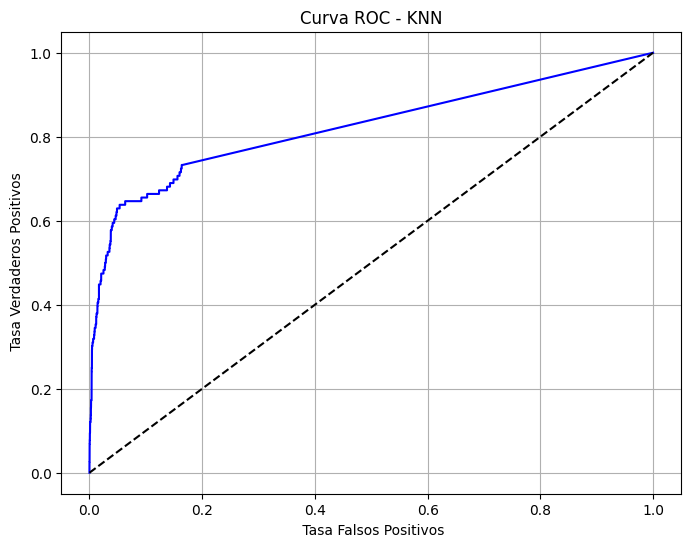

In [45]:
fpr, tpr, thresholds = roc_curve(y_testbrd4, ypredknnbrd4)
knnaucbrd4 = roc_auc_score(y_testbrd4, ypredknnbrd4)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC KNN (AUC = {knnaucbrd4:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - KNN')
plt.grid(True)
plt.show()

Gráficamente observamos que la curva está un poco más cercana a la diagonal comparada con las demás observaciones, esto quiere decir que el modelo predice bien pero no tanto como los anteriores. Esto se reafirma con su AUC de 0.822578 que implica que tiene un rendimiento más aceptable que bueno.

Vemos que no hay un balance entre ambas tasas/proporciones,

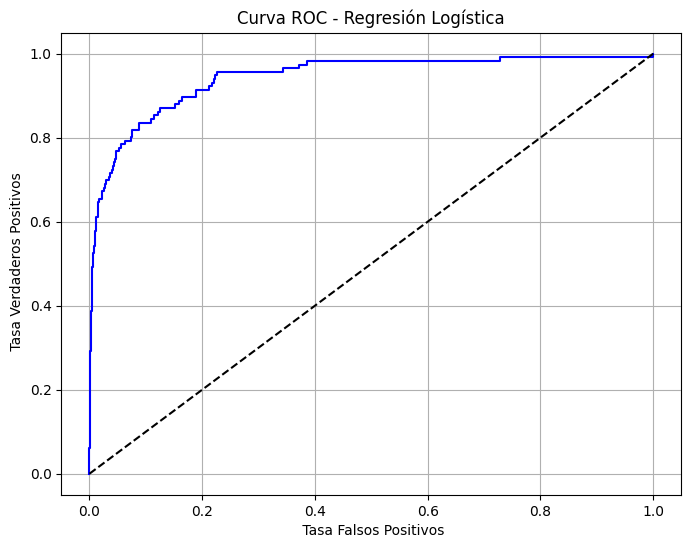

In [46]:
fpr, tpr, thresholds = roc_curve(y_testbrd4, ypredlrbrd4)
lraucbrd4 = roc_auc_score(y_testbrd4, ypredlrbrd4)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC KNN (AUC = {lraucbrd4:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.grid(True)
plt.show()

Esta gráfica presenta una curva bastante alejada de la diagonal, insinuando así que el modelo tiene un alto poder predictivo. Esto puede confirmarse con el score del conjunto de prueba obtenido: 0.943116, lo cual implica que se presentó un buen rendimiento.

### Proteína ALB - HSA

Primero se importa la base de datos de interés.

In [47]:
datahsa = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/datatrainhsa.csv")

Ahora los modelos.

#### KNN

In [48]:
X_hsa = datahsa.drop(columns='binds')  
y_hsa = datahsa['binds'] 

X_trainhsa, X_testhsa, y_trainhsa, y_testhsa = train_test_split(X_hsa, y_hsa, stratify= y_hsa, random_state=21)

In [49]:
knn_pipelinehsa = Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsClassifier(weights='distance'))]) #Creación del Pipeline
knn_paramgridhsa = {'KNN__n_neighbors': list(range(1,150))} #Parámetro grid

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 21)

knn_gridhsa = GridSearchCV(knn_pipelinehsa, knn_paramgridhsa, cv=skf, scoring='roc_auc')
knn_gridhsa.fit(X_trainhsa, y_trainhsa)

print("Mejor score de conjunto de entrenamiento :", knn_gridhsa.best_score_)
print("Mejor parámetro: ", knn_gridhsa.best_params_)

ypredknnhsa = knn_gridhsa.predict_proba(X_testhsa)[:, 1]
auc = roc_auc_score(y_testhsa, ypredknnhsa)

print('Mejor score de conjunto de test:', auc)

Mejor score de conjunto de entrenamiento : 0.8097874660582345
Mejor parámetro:  {'KNN__n_neighbors': 147}
Mejor score de conjunto de test: 0.8120102704172435


Se puede decir que el modelo estuvo bien entrenado pues el score del test es superior al de entrenamiento. Por otra parte, cabe mencionar que la cantidad óptima de vecinos es 147.

#### Regresión logística

In [50]:
X_hsa = datahsa.drop(columns='binds')  
y_hsa = datahsa['binds'] 

X_trainhsa, X_testhsa, y_trainhsa, y_testhsa = train_test_split(X_hsa, y_hsa, stratify= y_hsa, random_state=21)

In [51]:
lr_pipelinehsa = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())]) 
lr_paramgridhsa = {'lr__C': [0.01, 0.1, 1, 10, 100]}

lr_gridhsa = GridSearchCV(lr_pipelinehsa, lr_paramgridhsa, cv=5, scoring='roc_auc')
lr_gridhsa.fit(X_trainhsa, y_trainhsa)

ypredlrhsa = lr_gridhsa.predict_proba(X_testhsa)[:,1]
auc = roc_auc_score(y_testhsa, ypredlrhsa)

print("Mejor score de conjunto de entrenamiento:",lr_gridhsa.best_score_)
print("Mejor parámetro: ", lr_gridhsa.best_params_)
print('Mejor score de conjunto de test:',auc)

Mejor score de conjunto de entrenamiento: 0.889083999520874
Mejor parámetro:  {'lr__C': 0.01}
Mejor score de conjunto de test: 0.8741580358908444


En este caso tenemos que el mejor parámetro es 0.01, viendo que los scores de entrenamiento y test son cercanos.

#### Cuadro 3: Modelo de clasificación para predicción de unión entre molécula y proteína HSA. 

In [53]:
KNN_hsa = knn_gridhsa.predict(X_testhsa)
LR_hsa = lr_gridhsa.predict(X_testhsa)

probknnhsa = knn_gridhsa.predict_proba(X_testhsa)[:, 1]
problrhsa = lr_gridhsa.predict_proba(X_testhsa)[:, 1]

metricas = {
    'Modelo': ['KNN', 'Regresión logística'],
    'Precision': [
        precision_score(y_testhsa, KNN_hsa), # K-NN
        precision_score(y_testhsa, LR_hsa) # Regresión logística
    ],
    'Recall': [
        recall_score(y_testhsa, KNN_hsa),
        recall_score(y_testhsa, LR_hsa)
    ],
    'F1 Score': [
        f1_score(y_testhsa, KNN_hsa),
        f1_score(y_testhsa, LR_hsa)
    ],
    'ROC AUC': [
        roc_auc_score(y_testhsa, probknnhsa), 
        roc_auc_score(y_testhsa, problrhsa)  
    ]
}

cuadro3 = pd.DataFrame(metricas)
cuadro3 

,Modelo,Precision,Recall,F1 Score,ROC AUC
0,KNN,0.312500,0.048077,0.083333,0.812010
1,Regresión logística,0.416667,0.048077,0.086207,0.874158


Al igual que como se venía observando, se puede decir que el modelo de regresión logística se entrenó mejor dado que sus scores son mayores en todas las métricas.

#### Matrices de confusión

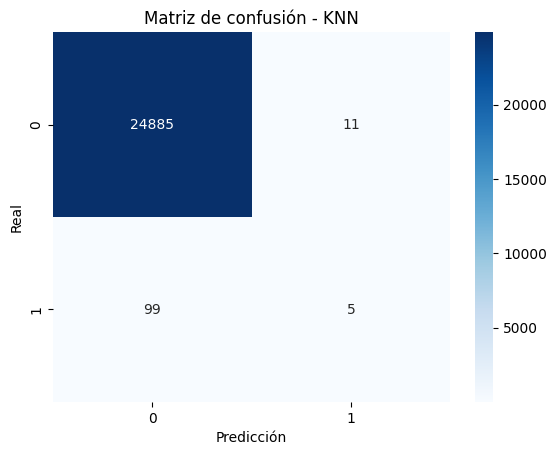

In [54]:
ypredknnhsa_cm = (ypredknnhsa >= 0.5).astype(int)

knncmhsa = confusion_matrix(y_testhsa, ypredknnhsa_cm)

sns.heatmap(knncmhsa, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - KNN')
plt.show()

Dado el gran desbalance en la base de datos, observamos que en una nueva ocasión los verdaderos negativos son las que más predicciones obtuvieron. Hay solamente 5 verdaderos positivos, y entre el grupo de los falsos, los negativos obtuvieron más predicciones que los verdaderos.

Es decir, este modelo predice más a los negativos pues el porcentaje de 0 en la base es de más del 95%.

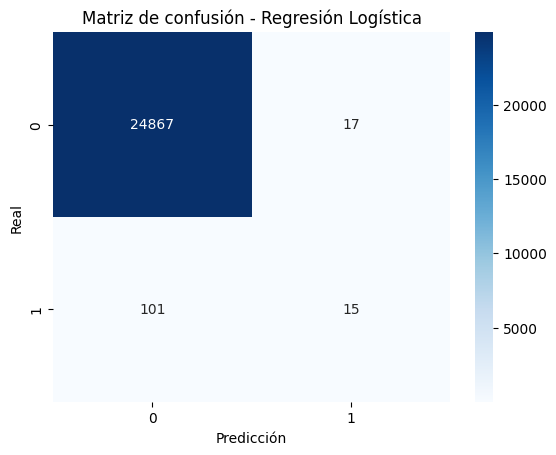

In [55]:
ypredlrhsa_cm  = (ypredlrhsa  >= 0.5).astype(int)

lrcmhsa = confusion_matrix(y_testhsa, ypredlrhsa_cm)

sns.heatmap(lrcmbrd4, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Regresión Logística')
plt.show()

Cuenta con un alto número de verdaderos negativos, 24867,pero los verdaderos positivos son muy pocos, 15. En cuanto a las predicciones falsas, ambas cantidades son bastantes pequeñas también, sin embargo, la de los negativos (101) es mayor a la de los positivos (17).

#### Curvas ROC

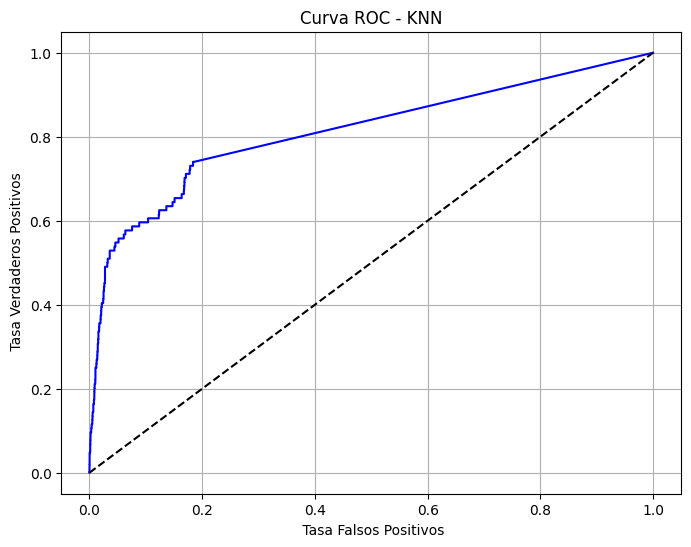

In [56]:
fpr, tpr, thresholds = roc_curve(y_testhsa, ypredknnhsa)
knnauchsa = roc_auc_score(y_testhsa, ypredknnhsa)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC KNN (AUC = {knnauchsa:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - KNN')
plt.grid(True)
plt.show()

En este caso observamos una curva relativamente alejada de la diagonal, esto nos indica que puede llegar a ser un buen predictor, sin embargo, su AUC es de 0.812010 y la curva no pasa cercana a (0,1), lo cual implica que el modelo tiene la capacidad de clasificar correctamente en la mayoría de los casos pero puede mejorar su rendimiento.

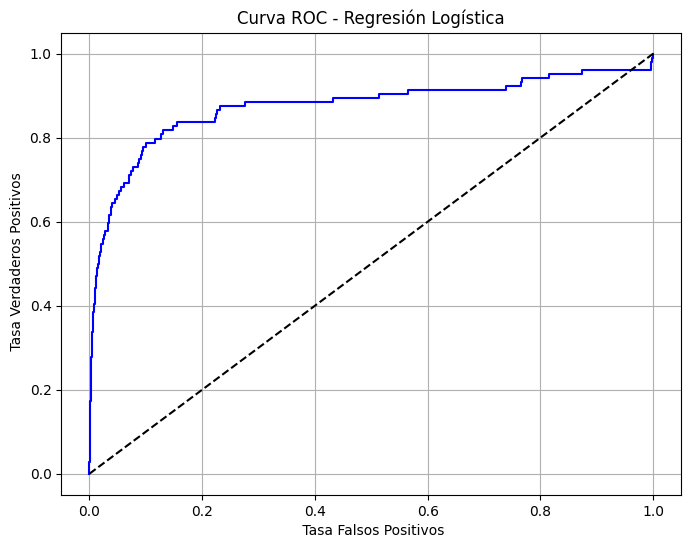

In [57]:
fpr, tpr, thresholds = roc_curve(y_testhsa, ypredlrhsa)
lrauchsa = roc_auc_score(y_testhsa, ypredlrhsa)

plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, label = f'Curva ROC KNN (AUC = {lrauchsa:.2f})', color = 'blue')
plt.plot([0,1], [0,1], color ='black', linestyle='--')
plt.xlabel(' Tasa Falsos Positivos')
plt.ylabel(' Tasa Verdaderos Positivos')
plt.title('Curva ROC - Regresión Logística')
plt.grid(True)
plt.show()

Para este modelo vemos una curva mejor, está un poco más cercana al (0,1) por lo que podemos suponer que la tasa de verdaderos positivos es relativamente mayor a la de verdaderos positivos. Además, tiene un AUC mayor al de KNN igual a 0.874158

### Justificación validación cruzada

Como se pudo observar, en el desarrollo de este ejercicio se hizo uso de StratifiedKFold para la validación cruzada. Se optó por esta técnica dado que nuestras bases de datos cuentan con un gran desbalance, en donde prácticamente todas las observaciones pertenecen a la clase 0 en la variable binaria objetivo. Por esta razón es que decidimos escoger esta dado que lo ideal es que la proporcion de estas clases sea la misma en ambos conjuntos para que se hiciera un buen modelo predictivo sin sobreajuste al tener una distribución representativa de 0 y 1.

### Conclusiones

Luego de haber analizado las 3 proteínas, pudimos observar que en general el mejor modelo de predicción fue regresión logística pues en todas las ocasiones era la que contaba con mejor score en el test de prueba comparado con KNN.

Asímismo, observamos una tendencia marcada con ayuda de las matrices de confusión relacionada con el gran desbalance de la distribución de la variable `binds`. Esto se reflejó por medio de la gran cantidad de predicciones de verdaderos negativos y porque la cantidad de falsos negativos también era superior a los positivos en todos los casos.